# **Grupo 6 - G2: Sistema de Recomendação - Aprendizado de Máquina**
#### Members: Thomas Botelho (1421500), Lucca Buffara (1521018), Niklas Gerlach, Maria Cruz

The purpose of this report is to create a recommendation system based on the Amazon Review dataset from 2018. This dataset contains millions of reviews from May 1996 to Oct 2018, from the Amazon website. The full uncompressed dataset, considering only products with 5 or more reviews, weighs in at roughly 88 GB. In accordance with the authors' computing capacity, only reviews from the "Video Games" category are considered.

For this project, a few matrix factoring models specialized for non-negative ratings scores are considered. Most features available to us are not need for this kind of approach, which relies on `(user, product, rating)` triples to establish similarity scores amongst users. The chosen models are ranked in ascending order by their RMSE (root mean squared error) for predicted ratings on products from a testing set. An 80/20 random train test split is used along with 5-fold cross validation, in an attempt to ensure the robustness of our predictions. A grid search procedure is used to select locally optimal parameters for the model with the lowest measured error.

A recommendation system must provide a user with suggestions for products they might be interested in - often this does not include products they have already bought. The way we are measuring errors serves as an approximation in lieu of other better options, since we cannot show actual users our recommendations, we consider product ratings estimation as a proxy for out-of-sample recommendation performance. To allow for a qualitative evaluation of predictions, for each model, we display the top 10 recommendations considering only previously unseen products. 

In [1]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import data

import os
import json
import gzip
import random
import pandas as pd
import seaborn as sns
from urllib.request import urlopen

# COLAB - comment if using locally
from google.colab import drive
drive.mount("/content/drive/")
GZIP_PATH = "/content/drive/MyDrive/Amazon Video Games Recommender Dataset/Video_Games.json.gz"
METADATA_JSON_PATH = "/content/drive/MyDrive/Amazon Video Games Recommender Dataset/VideoGames_meta.json"

# LOCAL - comment if using Google Colab
# GZIP_PATH = "Video_Games.json.gz"
# METADATA_JSON_PATH = "VideoGames_meta.json"

def get_item(asin):
    return df_meta[df_meta['asin'].str.contains(asin)]

def get_recommendations(algo, uid):
    try:
        items_id = recommendations[algo][uid]
        return [get_item(item).head(1)['title'].iloc[0] for item in items_id]
    except KeyError:
        print("UID not found:", uid)

# Load metadata
with open(METADATA_JSON_PATH) as f:
    meta_json = json.load(f)

df_meta = pd.json_normalize(meta_json)

# Load data
data = []
with gzip.open(GZIP_PATH) as f:
    data.extend(json.loads(l.strip()) for l in f)

# Sort by date
data = sorted(data, key=lambda x: x['unixReviewTime'])

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,overall,count
0,5.0,1487366
1,4.0,412413
2,1.0,311891
3,3.0,212346
4,2.0,141333


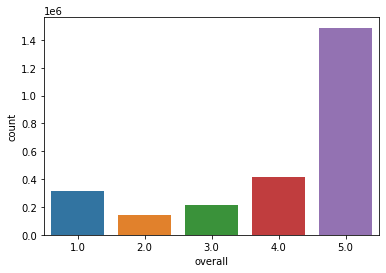

In [3]:
# Remove unwanted fields
for entry in data:
    if 'reviewTime' in entry:
        del entry['reviewTime']
    if 'style' in entry:
        del entry['style']
    if 'reviewerName' in entry:
        del entry['reviewerName']
    if 'reviewText' in entry:
        del entry['reviewText']
    if 'summary' in entry:
        del entry['summary']
    if 'image' in entry:
        del entry['image']

df = pd.DataFrame.from_dict(data)
df[['vote']] = df[['vote']].fillna(value=0)
df.head()

# Number of products for different ratings
df.groupby(['asin']).count()['overall']

overall_count = pd.DataFrame(df['overall'].value_counts()).reset_index()
overall_count.columns = ['overall', 'count']
sns.barplot(data=overall_count, x="overall", y="count")
display(overall_count)

Text(0.5, 1.0, 'Popular Products Bar Chart')

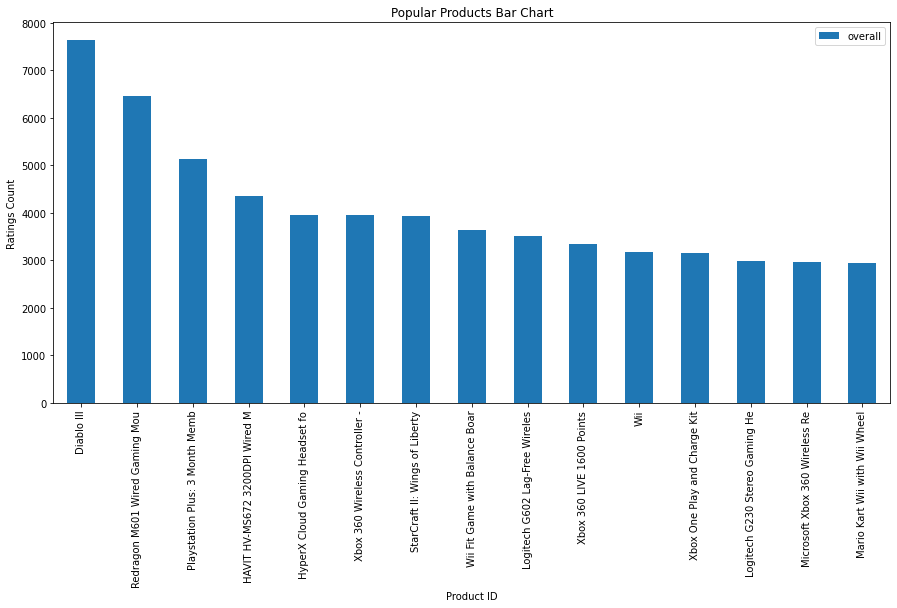

In [4]:
# Get popular products -- Products that have more than 1k reviews
popular_data = df.groupby("asin").filter(lambda x:x['overall'].count() >= 1000)
popular_products = pd.DataFrame(popular_data.groupby('asin')['overall'].count())
popular_products = popular_products.sort_values('overall', ascending=False)

dat = popular_products.head(15).reset_index()
dat["names"] = dat["asin"]
dat = dat.set_index("asin")
dat["names"] = dat["names"].apply(lambda x: get_item(x)["title"].values[0][:30])

ax = dat.plot(x = "names", y = "overall", kind = "bar", figsize=(15,7))
ax.set_xlabel("Product ID")
ax.set_ylabel("Ratings Count")
ax.set_title("Popular Products Bar Chart")

In [5]:
# Extract (user, product, rating) triples from the dataset

from surprise import SVD, SVDpp, CoClustering, KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise.model_selection import GridSearchCV

cf_data = df[['reviewerID', 'asin', 'overall']]
display( cf_data.head() )

reader = Reader(rating_scale=(1, 5))

full_data = Dataset.load_from_df(cf_data, reader)
predict_data = full_data.build_full_trainset()
traindata, testdata = train_test_split(full_data, test_size=0.3)

,reviewerID,asin,overall
0,AR9HFLYSXUOYS,B00000JL6V,5.0
1,A26Y5BK10TL1OI,B00000JL6V,5.0
2,A3VMPX6KW6VSQY,B00000JL6V,5.0
3,A3N83WBSOG9PE4,B00000JL6V,1.0
4,A2Q6FRINMH0R81,B00000JL6V,4.0


In [6]:
# Build anti test set, containing the missing (user, product) pairs considering all possible observed permutations, for a random user
fill = predict_data.global_mean

anti_testset = []
for u in traindata.all_users()[0:1]:
    user_items = {j for (j, _) in traindata.ur[u]}

    anti_testset += [
        (traindata.to_raw_uid(u), traindata.to_raw_iid(i), fill) for i in traindata.all_items() if i not in user_items ]

In [7]:
# Fit prediction algos
predict_algos = {
    "svd": SVD(n_epochs=25),
    "svdpp": SVDpp(n_epochs=25),
    "co-clustering": CoClustering(n_cltr_u=7, n_cltr_i=5)
}

test_algos = predict_algos.copy()

for key, algo in predict_algos.items():
    print(f"Fitting {key}...")
    predict_algos[key].fit(predict_data)
    test_algos[key].fit(traindata)

Fitting svd...
Fitting svdpp...
Fitting co-clustering...


In [8]:
# Test fitted prediction algos
for algo in predict_algos.values():
    predict_svd = algo
    predict_svd.fit(predict_data)

prediction = dict.fromkeys(predict_algos)
test = dict.fromkeys(predict_algos)

for key, algo in predict_algos.items():
    print(f"Testing, {key}...")
    prediction[key] = algo.test(anti_testset)
    test[key] = test_algos[key].test(testdata)

Testing, svd...
Testing, svdpp...
Testing, co-clustering...


In [13]:
# Number of items rated by given user
def get_Iu(uid):
    try:
        return len(traindata.ur[traindata.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
# Number of users that have rated given item
def get_Ui(iid):
    try: 
        return len(traindata.ir[traindata.to_inner_iid(iid)])
    except ValueError:
        return 0

p_df = {}
for key, p in prediction.items():
    p_df[key] = pd.DataFrame(p, columns=['uid', 'iid', 'rui', 'est', 'details'])
    p_df[key]['Iu'] = p_df[key].uid.apply(get_Iu)
    p_df[key]['Ui'] = p_df[key].iid.apply(get_Ui)
    p_df[key]['err'] = abs(p_df[key].est - p_df[key].rui)

# RMSE for each model
for key, res in test.items():
    print(f"--- {key} ---")
    acc = accuracy.rmse(res, verbose=True)

--- svd ---
RMSE: 0.5933
--- svdpp ---
RMSE: 0.6712
--- co-clustering ---
RMSE: 0.6145


In [10]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

N = 10
top_n = dict.fromkeys(predict_algos)
for key in prediction:
    top_n[key] = get_top_n(prediction[key], n=N)

for key, top in top_n.items():
    print(key)
    for uid, user_ratings in top.items():
        print("User ID:", uid, "Recommended items:", [iid for (iid, _) in user_ratings])

svd
User ID: A3R7E4B9PS3G61 Recommended items: ['B00136MBHA', 'B005C1B3C6', 'B00JK00S0S', 'B000066TS5', 'B00104UBY0', 'B0017KIBAI', 'B000OLXX86', 'B00JUFSH42', 'B019J6RYCW', 'B017L187YG']
svdpp
User ID: A3R7E4B9PS3G61 Recommended items: ['B002EE4VQY', 'B000OLXX86', 'B003OAE79S', 'B00ENFVJJO', 'B00L2FGSFI', 'B003L14Y9I', 'B006PP404Q', 'B00CMQTUY2', 'B0073QM45I', 'B00KXAGTV6']
co-clustering
User ID: A3R7E4B9PS3G61 Recommended items: ['B00CMN0Z0S', 'B00ZGPJ0TG', 'B007FQUFC0', 'B0054IN5RI', 'B000088KH9', 'B00004U34A', 'B00O9GW8TC', 'B014YE12CM', 'B00000JRSB', 'B00004YRQA']


In [11]:
# Top 10 recommendations for each model
recommendations = dict.fromkeys(predict_algos)
for key, top in top_n.items():
    print(f"--- {key} ---")
    recommendations[key] = {uid: [iid for (iid, _) in user_ratings] for uid, user_ratings in top.items()}
    random_user = random.choice(list(recommendations[key].keys()))
    print("Random user ID:", random_user)
    df = pd.DataFrame({"recommendation": get_recommendations(key, random_user)})
    display( df.head(N) )

--- svd ---
Random user ID: A3R7E4B9PS3G61


,recommendation
0,The World Ends With You
1,3C PRO 16GB 16G Class 10 C10 microSD microSDHC...
2,The Last of Us Remastered - PlayStation 4
3,Kingdom Hearts
4,"Mamas &amp; Papas Soft Toy, Peanut Elephant"
5,Official Nintendo White Classic Gamecube Contr...
6,Mass Effect - Xbox 360
7,Madden NFL 15 - PlayStation 3
8,Far Cry 4 - PS3 [Digital Code]
9,Overwatch - Origins Edition - PC


--- svdpp ---
Random user ID: A3R7E4B9PS3G61


,recommendation
0,Flip Travel Charger for Nintendo DS Lite
1,Mass Effect - Xbox 360
2,Xbox 360 Headset
3,PowerA DualShock 4 Charging Station for PlaySt...
4,Nyko Intercooler Stand - Cooling Attachment wi...
5,Monoprice 6-Feet Audio Video ED Component Cabl...
6,PlayStation Vita Protective Film - Two Pack
7,Xbox One Wireless Controller and Play &amp; Ch...
8,Insten Wireless Controller USB Charging Cable ...
9,Grand Theft Auto V - PC Download [Download]


--- co-clustering ---
Random user ID: A3R7E4B9PS3G61


,recommendation
0,60GB Hard Disk Drive for Xbox 360 Slim
1,Plants vs. Zombies Garden Warfare 2 - Xbox One
2,Warriors Orochi 3 - Xbox 360
3,The King of Fighters XIII - Xbox 360
4,Tenchu: Wrath of Heaven
5,Hogs of War
6,Nintendo Super Smash Bros. White Classic Gamec...
7,Nitroplus Blasterz: Heroines Infinite Duel - P...
8,Final Fantasy VII
9,PlayStation 2 Memory Card (8MB)


Out of the three matrix factorization models tested, `SVD`, `SVDpp`, and `Co-Clustering`, the one with the best RMSE on the randomized testing set was the "classic" `SVD`. As mentioned previously, using a train test split is not the best way to evaluate performance, since we cannot show recommendations to people live. A better way without live access might be to check the probability of the model's top product recommendations being on a recomendee's wishlist of products.

A grid search is executed on `SVD` in hopes of finding optimal parameters for our situation. The resulting model is not appropriate for an online learning type of situation, since it cannot be trained incrementally and takes a resonable amount of time to train. For use in production, it would have to be trained nightly or weekly in order to continually refresh and improve its recommendations. A positive aspect of matrix factorization methods, at least at our scale, is that inference is very efficient, since in a sense the basis for all possible recommendations is pre-computed.

In [ ]:
# Notebook runs out of RAM during execution!
param_grid = {"n_epochs": [5, 10, 25, 50], "lr_all": [0.0025, 0.005, 0.0075], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])